###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.

# Riding the wave

We've reached the third lesson of the module _Riding the wave: Convection problems_, where we explore the numerical solution of conservation laws. We learned in the [first lesson](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb) how to think about conservation laws, starting with the most intuitive case: that of conservation of mass. But there are many physical quantities that can be conserved: energy, for example. Or cars on a road.

Developing a conservation law for traffic in a one-lane roadway is fun, because we can relate to the insights it gives. We've all experienced traffic slowing down to a crawl when the density of cars gets very high, and stepping on the accelerator pedal with glee when there are no cars on the road!

In the previous two lessons, we developed a traffic-flow model and explored [different choices of numerical scheme](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb).  Not everything worked as you expected, and by now you might be realizing how some restrictions come about from the numerical methods themselves, while others still are imposed by the models we use. This lesson will develop a better traffic model, and also show you some impressive SymPy kung fu.

## Traffic flow, revisited

### A better flux model

Like you saw in the first lesson, cars obey a typical conservation law,

\begin{equation}
 \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0, \end{equation}

where $F$ is the flux, $F=\rho u$—flux equals density times velocity. From our experience on the road, we know that the traffic speed is a function of traffic density, and we proposed as a first approximation a linear relation between the two. Thus,

\begin{equation}
F(\rho) = \rho \, u_{max}\left(1 - \frac{\rho}{\rho_{max}} \right)
\end{equation}

This flux model meets the two requirements, based on a qualitative view of traffic flow, that:
1.  $u \rightarrow u_{max}$ and $F\rightarrow 0$ when $\rho \rightarrow 0$.
2.  $u \rightarrow 0$ as $\rho \rightarrow \rho_{max}$

However, it leads to some unrealistic or at least improbable results.  For example, note that if the traffic speed is a linear function of density, the flux function will be quadratic (see Figure 1). In this case, the maximum flux will occur when $\rho^{\star} = \rho_{max}/2$, corresponding to a traffic speed $u_{max}/2$.  

![velocity_and_flux](./figures/velocity_and_flux.png)
#### Figure 1. Traffic speed (left) and flux (right) vs. density.

A good question to ask here is:  should the maximum flux on a given stretch of road have a strict dependence on the maximum speed that the roadway allows, be it by physical restrictions or posted speed limits? In other words, do we really expect the maximum flux to increase if we allow arbitrarily high speeds? 

Probably not.  But there *should* be some ideal traffic speed, $u^{\star}$, corresponding to an ideal traffic density, $\rho^{\star}$, resulting in the maximum traffic flux:

\begin{equation}F_{\rm max} = \rho^{\star}u^{\star}\end{equation}

Let us improve the initial flux model by taking this observation into account. One thing that we can try is to introduce a flux model that is cubic in $\rho$ instead of quadratic:

\begin{equation}F(\rho) = u_{\rm max}\rho (1 - A\rho - B \rho^2)\end{equation}

This new model still meets the first criterion listed above: $F\rightarrow 0$ when $\rho \rightarrow 0$. Moreover, we impose the following conditions:

*  When $\rho = \rho_{\rm max}$ traffic flux goes to zero:

\begin{equation}F(\rho_{\rm max}) = 0 = u_{\rm max}\, \rho_{\rm max}(1 - A \rho_{\rm max} - B \rho_{\rm max}^2)\end{equation}

*  Based on eq. (3), maximum flux occurs when $\rho = \rho^{\star}$ and $F'(\rho^{\star}) = 0$:

\begin{equation}
F'(\rho^{\star}) = 0  = u_{\rm max}(1 - 2A\rho^{\star} - 3B(\rho^{\star})^2)\end{equation}

*  $u^{\star}$ is obtained when $\rho = \rho^{\star}$:

\begin{equation}
u^{\star} = u_{\rm max}(1 - A \rho^{\star} - B(\rho^{\star})^2)\end{equation}

We have three equations and four unknowns $A,B,\rho^{\star}, u^{\star}$. However, in practice, the ideal traffic speed could be obtained for a given road by observations. Similarly to $u_{max}$ and $\rho_{max}$ it will therefore be taken as a parameter.

### Solving the new flux equation

Equations $(5)$, $(6)$, and $(7)$ are not incredibly difficult to solve with pen and paper. Instead of following that route, we can use [SymPy](http://sympy.org/en/index.html), the symbolic mathematics library of Python.  You used SymPy already in the [Burgers' equation lesson](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_04_1DBurgers.ipynb) of Module 2, _"Space & Time"_, and you will learn some new functionalities here.

We begin by importing SymPy, initializing $\LaTeX$ printing and defining a set of symbolic variables that we'll use in the calculations. Remember: variables are not defined automatically, you have to tell SymPy that a name will correspond to a symbolic variable by using the keyword `symbols`. This behavior is different from many other symbolic math systems that implicitly construct symbols for you, so you may be perplexed if you've used these other sytems before. The reason for this behavior in SymPy is that the system is fully built on Python, a general-purpose language that needs you to define all objects before using them.

In [6]:
import sympy
sympy.init_printing()

(u_max, u_star, rho_max, 
 rho_star, A, B) = sympy.symbols('u_max u_star rho_max rho_star A B')

Notice that we used the special character `_` (the under-dash) to create a symbol with a subscript. Here, for example, we've created the symbols $u_{max}$ and $u_{star}$, representing $u_{\rm max}$ and $u^{\star}$ ($u$-star) in the equations, and assigned them to the variable names `u_max` and `u_star`. SymPy also allows you to create symbols with a superscript by means of the special character `^`. Be careful, though: SymPy is built on Python, so you denote an exponent in an expression by `**` (this may also be different from other symbolic math systems that you have used in the past).

Next, use `sympy.Eq()` to define the three equations—corresponding to Equations $(5)$, $(6)$ and $(7)$, above—in terms of symbolic variables. The function `sympy.Eq()` creates an equality between two SymPy objects, passed as arguments separated by a comma. We need to remember that the equal sign in Python is used for variable assignment, and for that reason it cannot be used to build a symbolic equation with SymPy. That is why we need `sympy.Eq()` to create symbolic equalities. But the equal sign _is_ used to _assign_ an equation to a name: here, `eq1`, `eq2`, `eq3` are names for the symbolic equalities we create with `sympy.Eq()`.

In [7]:
eq1 = sympy.Eq( 0, u_max*rho_max*(1 - A*rho_max-B*rho_max**2) )
eq2 = sympy.Eq( 0, u_max*(1 - 2*A*rho_star-3*B*rho_star**2) )
eq3 = sympy.Eq( u_star, u_max*(1 - A*rho_star - B*rho_star**2) )

Check this out: you can display these equations in pretty typeset mathematics just by executing their name in a code cell:

In [8]:
eq1

In [9]:
eq2

In [10]:
eq3

As stressed above, we have three equations with three unknowns (assuming we have some observed value of $u_{star}$, corresponding to the ideal traffic speed)—there must be a solution!

To eliminate the term with $B$ in `eq2`, leaving it only in terms of $A$ and $\rho^{\star}$, we might subtract `3*eq3`.  But this will not work in SymPy if you attempt equation subtraction using the equation names. Just like we couldn't use the equal sign (which in Python means assignment) to create a symbolic equality (needing `sympy.Eq` instead), we can't use mathematical operators directly on the SymPy equations, because they are really _equalities_. What does it mean to subtract two _equalities_? It doesn't make sense. Try it ...

In [11]:
eq2 - 3*eq3

See?  SymPy just printed out what you suggested but it did not manipulate algebraically the left and right sides of `eq2` like we were aiming for. What we _can_ do is create a _new_ equation, perform the left-hand side (LHS) and right-hand side (RHS) operations separately and then recombine them into our desired result. For this, it is helpful to know that there are built-in properties of a SymPy equality for the left-hand side and the right-hand side of the equality. Check it out:

In [12]:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4

That still needs a little work. SymPy offers several methods to help reduce expressions. You can use [`simplify()`](http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=simplify#sympy.simplify.simplify.simplify) to attempt to make the expression "simpler," but you can imagine that the quality of an expression being simple is not well defined. One may expect the simpler expression to be shorter, maybe; but not always. The SymPy `simplify()` function applies several strategies, heuristically, to give you an equivalent reduced expression. But some expressions are uncooperative and `simplify()` gives up, returning the argument unchanged. Let's see what it can do with our expression `eq4`.

In [13]:
eq4.simplify()

That is actually a useful result. We see that `eq4` allows solving for $\rho^{\star}$ in terms of $A$, for example (remember that $u_{max}$ is known: the road's maximum velocity). Then we could try to manipulate `eq1` to solve for $B$ in terms of $A$, as well, so that we can substitute back in `eq2` leaving everything in terms of $A$. We can do all that without the help of `simplify()`, but using it interactively to reason about the long expression helped us to decide on a course of action.

Another SymPy function that can help us examine complicated expressions is [`expand()`](http://docs.sympy.org/latest/modules/core.html?highlight=expand#sympy.core.function.expand). Its purpose is to expand bracketed factors in expressions and group powers of symbols. Let's see what that does here. Notice first that `eq4` hasn't changed; we just printed the result of applying `simplify()` to it.

In [14]:
eq4

And now we print the result of applying `expand()` to it.

In [15]:
eq4.expand()

That's very similar to our previous result, except without the bracketed factor. Simplifying an expression can be accomplished by expanding or factoring terms, or a combination of the two. Whether to `simplify()` or `expand()` depends on the situation and you just have to experiment.

We now have an idea of what to do with our three equations. We'll get expressions in terms of $A$ from `eq4` and `eq1` and substitute them back into `eq2`. For that, we can use the SymPy functions [`solve()`](http://docs.sympy.org/dev/modules/solvers/solvers.html#sympy.solvers.solvers.solve) and `subs()`, respectively. The arguments to `solve()` are the equality that needs to be solved, and the symbol to solve for.

**Note**: `sympy.solve()` always returns results in a *list*, since you often end up with multiple solutions for a given variable.  These linear equations will only return one solution, so we can skip a step and ask right away for the `[0]`-th element of the list.

In [16]:
rho_sol = sympy.solve(eq4,rho_star)[0]
rho_sol

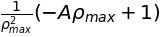

In [17]:
B_sol = sympy.solve(eq1,B)[0]
B_sol

The arguments to the SymPy function [`subs()`](http://docs.sympy.org/dev/modules/core.html#sympy.core.basic.Basic.subs) are given as (old, new) pairs, where the "new" expression substitutes the "old" one. So here, in `eq2`, we substitute `rho_sol` in place of `rho_s` and we substitute `B_sol` in place of `B`.

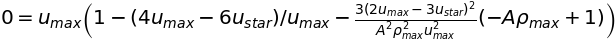

In [18]:
quadA = eq2.subs([(rho_star, rho_sol), (B,B_sol)])
quadA

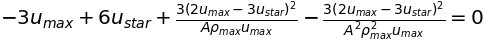

In [19]:
quadA.simplify()

It's a little bit ugly, but that is quadratic in $A$, and that means we can solve for the roots of the equation. SymPy's `solve()` function in this case will return a list with the two roots. They are long expressions, so let's print each root separately.

In [20]:
A_sol = sympy.solve(quadA, A)

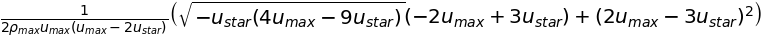

In [21]:
A_sol[0]

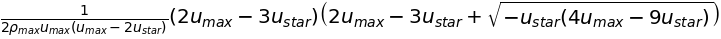

In [22]:
A_sol[1]

### Evaluating the new flux equation

Quadratic equations, of course, have two solutions. Here we have to select the positive root, otherwise our model would have an inconsistency. Are you able to see why?  To determine its value, we need to fill in some actual numbers into the model.

Let's start with the same numerical values that we used in [lesson 1](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb) for $\rho_{\rm max}$ and $u_{\rm max}$. But we also have to supply a value for $u^{\star}$, a quantity that should be experimentally observed in a given road. We propose $u^{\star} = 0.7\, u_{\rm max}$ for this exercise.  This would correspond to 84 km/h for a highway with a 120-km/h speed limit, for example.

Let's numerically evaluate the solutions for $A$ using the following values:

\begin{align} 
\rho_{\rm max} &=10.0 \nonumber\\ u_{\rm max} &=1.0 \nonumber\\ u^{\star} &=0.7 \nonumber
\end{align}

Now evaluate the numeric result for each root of $A$ using the `evalf()` function, where you pass the numeric substitution as an argument. It's very cool.  Let's evaluate both roots and we will pick the positive one.

Let's try the `[0]`-th solution for $A$, first:

In [29]:
aval_a = A_sol[0].evalf(subs={u_star: 1.5, u_max:2.0, rho_max:15.0} )
aval_a

Now let's try the `[1]`-th solution for $A$:

In [30]:
aval_b = A_sol[1].evalf(subs={u_star: 1.5, u_max:2.0, rho_max:15.0} )
aval_b

Because Sympy seems not to return the roots in a deterministic order and  we want to use the positive root, we will automatically pick this one by using an `if` statement.

In [31]:
if aval_a > aval_b:
    aval = aval_a
else:
    aval = aval_b

In [32]:
aval

Now, numerically evaluate $B$ in the same way using the positive root `aval`:

In [34]:
bval = B_sol.evalf(subs={rho_max:15.0, A:aval} )
bval

### Turn off $\LaTeX$

$\LaTeX$ output is great when we're looking at algebraic expressions, but it's a little too much for simple numeric output.  Let's turn it off for the rest of the exercise:

In [35]:
sympy.init_printing(use_latex=False)

## Green light: take 2

Let's re-examine the green-light problem from [lesson 1](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb) but using our newly computed traffic-flux equation.  We shouldn't have to change much—in fact, we can simply create a new `computeF` function and leave the rest of the code unchanged.

There's one last bit of housekeeping to do so we don't run into trouble -- we used the variables `rho_max` and `u_max` in our SymPy code and we defined them as SymPy `symbols`.  You can check on the status of a variable using `type()`.  

In [36]:
print(type(rho_max), type(u_max))

<class 'sympy.core.symbol.Symbol'> <class 'sympy.core.symbol.Symbol'>


If we try to use SymPy variables with NumPy arrays, Python is going to be very unhappy.  We can re-define them as floats and avoid that messy situation.   

In [39]:
rho_max = 15.
u_max = 2.

In [40]:
def computeF(u_max, rho, aval, bval):
    return u_max*rho*(1 - aval*rho-bval*rho**2)

In [41]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [42]:
def rho_green_light(nx, rho_light):
    """Computes "green light" initial condition with shock, and linear distribution behind

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_light : float
        Density of cars at stoplight

    Returns
    -------
    rho_initial: array of floats
        Array with initial values of density
    """    
    rho_initial = numpy.arange(nx)*2./nx*rho_light  # Before stoplight
    rho_initial[int((nx-1)/2):] = 0
    
    return rho_initial

In [43]:
#Basic initial condition parameters
#defining grid size, time steps
nx = 81
nt = 30
dx = 4.0/(nx-1)

x = numpy.linspace(0,4,nx)

rho_light = 5.5


In [44]:
rho_initial = rho_green_light(nx, rho_light)

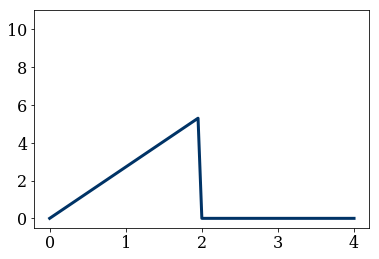

In [45]:
pyplot.plot(x, rho_initial, color='#003366', ls='-', lw=3)
pyplot.ylim(-0.5,11.);

In [46]:
def ftbs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with forward in time, backward in space
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho))) 
    
    #copy the initial u array into each row of our new array
    rho_n[0,:] = rho.copy()              
    
    for t in range(1,nt):
        F = computeF(u_max, rho, aval, bval)
        rho_n[t,1:] = rho[1:] - dt/dx*(F[1:]-F[:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()

    return rho_n

In [47]:
sigma = 1.
dt = sigma*dx/u_max

rho_n = ftbs(rho_initial, nt, dt, dx, rho_max, u_max)

In [48]:
from matplotlib import animation
from IPython.display import HTML

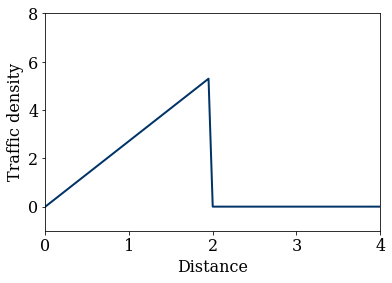

In [49]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(-1,8),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)

In [50]:
HTML(anim.to_html5_video())

That definitely looks different!  Do you think this is more or less accurate than our previous model?

##### Dig Deeper

The new traffic-flux model that we developed here changes the way that traffic patterns evolve. In this lesson, we only experimented with the most basic scheme: forward-time, backward-space.  Try to implement the green-light problem using one of the second-order schemes from [Lesson 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb).

## References

* Neville D. Fowkes and John J. Mahony, *"An Introduction to Mathematical Modelling,"* Wiley & Sons, 1994. Chapter 14: Traffic Flow.

---

###### The cell below loads the style of the notebook.

In [1]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())